# <center><u> Final LSTM/GRU Layout - Adri and Elian

In [1]:
#Import Libraries and Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
#Access Credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [4]:
query="""
    select * 
    from agg.tidy_data_final
    where site = 20
"""

In [5]:
df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_63440\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [6]:
df = df.set_index('timestamp', drop=False)
df = df.sort_index()

# Prepare Data Set for LSTM/GRU Models

In [7]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 1 day = 2 * 24 * 1 = 24
# 2 hours = 2 * 2 = 8 

n_input = 144
n_features = 5 #These includes the weather predictions that will be added later on and the normalised varaibles to be created
n_output = 72


# Select features of use for later on
df_input = df[['net_load', 'precipitation_probability',
               'solar_radiation','sunshine_duration','weekend_or_bank_holiday']]

# Normalise Data (as seen in Literature)

Group decision to use MaxAbs Scaler to normalise the data.

In [8]:
#Normalise all continuous variables needing scaling
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

variables = ['net_load','solar_radiation','sunshine_duration', 'precipitation_probability' ]
for var in variables:
    new_var_name = var + '_norm'
    df_input[new_var_name] = scaler.fit_transform(df_input[[var]])

C:\Users\elian\AppData\Local\Temp\ipykernel_63440\2851785778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
C:\Users\elian\AppData\Local\Temp\ipykernel_63440\2851785778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
C:\Users\elian\AppData\Local\Temp\ipykernel_63440\2851785778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Now, we also want to include the predictions for 'solar radiation', 'sunshine_duration', 'precipitation_probability' as inputs.
These will be treated as new inputs (t+48) ~ 48 half-hourly timestamps representing day-ahead predictions.

In [9]:
df_input['sunshine_duration_norm(t+48)'] = df_input['sunshine_duration_norm'].shift(-48) #Add prediction for time the day after
df_input['solar_radiation_norm(t+48)'] = df_input['solar_radiation_norm'].shift(-48) #Add prediction for time the day after
df_input['precipitation_probability_norm(t+48)'] = df_input['precipitation_probability_norm'].shift(-48) #Add prediction for time the day after

C:\Users\elian\AppData\Local\Temp\ipykernel_63440\1327219898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['sunshine_duration_norm(t+48)'] = df_input['sunshine_duration_norm'].shift(-48) #Add prediction for time the day after
C:\Users\elian\AppData\Local\Temp\ipykernel_63440\1327219898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['solar_radiation_norm(t+48)'] = df_input['solar_radiation_norm'].shift(-48) #Add prediction for time the day after
C:\Users\elian\AppData\Local\Temp\

In [10]:
#We want to drop last 48 rows as they will have Na values for the (t+48) columns/inputs.
df_input.dropna(inplace=True)

C:\Users\elian\AppData\Local\Temp\ipykernel_63440\1212278532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.dropna(inplace=True)


In [11]:
# Only Keep the Normalised Variables for the Model
df_input = df_input[['net_load_norm', 'weekend_or_bank_holiday', 'sunshine_duration_norm(t+48)',
               'solar_radiation_norm(t+48)','precipitation_probability_norm(t+48)']]

# Generate X and Y Matrices

In [12]:
X, y = [], []
for i in range(len(df_input) - n_input - n_output + 1):
    # Select all columns for the input sequence
    X.append(df_input.iloc[i:(i + n_input)].values)  
    
    y.append(df_input['net_load_norm'].iloc[(i + n_input):(i + n_input + n_output)].values)

X = np.array(X).reshape((len(X), n_input, -1))  
y = np.array(y)

# Train and Test Split

In [13]:
# 1 time step = 30 mins

n_split = 2 * 24 * 324

X_train = X[:n_split]
y_train = y[:n_split]

X_test = X[n_split:]
y_test = y[n_split:]

# Build and Fit LSTM/ GRU Models

In [14]:
# Import all Necessary Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
#GRU Model - just change GRU for LSTM to retrain
#Model Architecture
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LeakyReLU(alpha=0.01)) 
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.01)) 
model.add(BatchNormalization())
model.add(LSTM(64))
model.add(LeakyReLU(alpha=0.01)) 
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

In [15]:
# LSTM Model
model = Sequential()

model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True ))
model.add(BatchNormalization()) 
model.add(LeakyReLU(alpha=0.01)) 

model.add(LSTM(32))
model.add(BatchNormalization()) 
model.add(LeakyReLU(alpha=0.01)) 

model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

optimizer = Adam(learning_rate=0.001)

In [16]:
#Compile Model
cp1 = ModelCheckpoint('final_model.keras', save_best_only=True)
model.compile(loss='mse', optimizer=optimizer,  metrics=[MeanSquaredError(), MeanAbsoluteError()])

In [17]:
#Fit Model to Training Data with 10% Validation Split
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, callbacks=[cp1])

Epoch 1/10
875/875 [==============================] - 44s 48ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1400 - val_loss: 0.0115 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0734
Epoch 2/10
875/875 [==============================] - 43s 49ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0913 - val_loss: 0.0110 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0681
Epoch 3/10
875/875 [==============================] - 43s 49ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0838 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0686
Epoch 4/10
875/875 [==============================] - 43s 49ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0800 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0691
Epoch 5/10
875/875 [==============================] - 43s 49ms/step - loss: 0.0130 - mea

# Train Outputs 

### Get MAE and MSE Values

In [18]:
_, train_mse, train_mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")

486/486 [==============================] - 8s 17ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0661
Train MSE: 0.00998839270323515
Train MAE: 0.06611081957817078


### Visualise

1/1 [==============================] - 0s 28ms/step


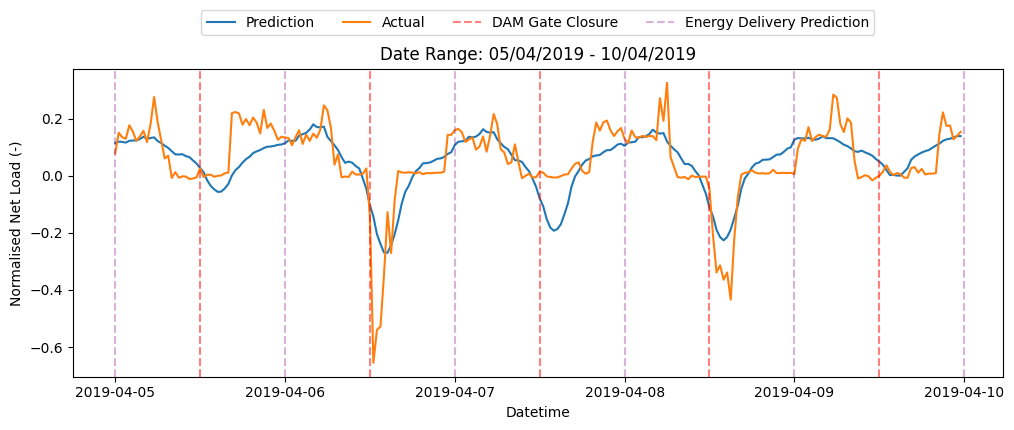

In [19]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 0
end_section = 5
diff = end_section-start_section

df_ts_train = df_input[n_input:n_split]

X_train_shift = X_train[24:]
y_train_shift = y_train[24:]

X_train_input = X_train_shift[::48]
y_train_input = y_train_shift[::48]


predictions = []

for i in X_train_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_train_input_24h = []

for i in y_train_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_train_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Date Range: {df_ts_train.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_train.index[end_section*48+48].strftime('%d/%m/%Y')}")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(y_train_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_train.index[start_section*48+72: (end_section)*48+72][::48]

for i, xc in enumerate(xcoords_DAM):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



# Generate vertical lines for DAM closure
xcoords_pred = df_ts_train.index[start_section*48+48: (end_section+1)*48+48][::48]

for i, xc in enumerate(xcoords_pred):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Test Outputs


### Get MAE and MSE Values

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]

predictions = []

for i in X_test_input:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])

# Flatten the lists of lists into single lists
predictions_flat = [item for sublist in predictions for item in sublist]
y_test_flat = [item for sublist in y_test_input_24h for item in sublist]

# Calculate MSE
test_mse = mean_squared_error(y_test_flat, predictions_flat)

# Calculate MAE
test_mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")


1/1 [==============================] - 0s 25ms/step
Test MSE: 0.018216754641010465
Test MAE: 0.08834432077610387


1/1 [==============================] - 0s 25ms/step


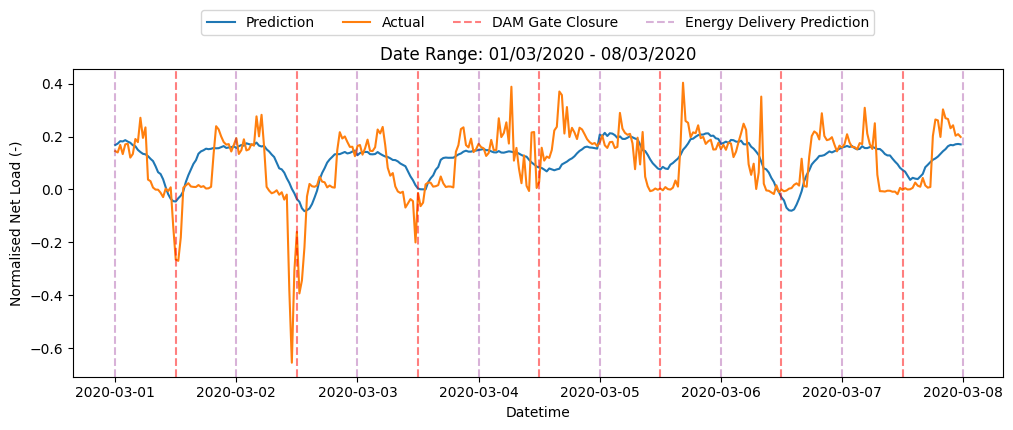

In [21]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 7
end_section = 14
diff = end_section-start_section

df_ts_test = df_input[n_input+n_split:]

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]



predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Date Range: {df_ts_test.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_test.index[end_section*48+48].strftime('%d/%m/%Y')}")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(y_test_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_test.index[start_section*48+72: (end_section)*48+72][::48]

for i, xc in enumerate(xcoords_DAM):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



# Generate vertical lines for DAM closure
xcoords_pred = df_ts_test.index[start_section*48+48: (end_section+1)*48+48][::48]

for i, xc in enumerate(xcoords_pred):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Random Search - Hyperparameter Tuning

Hyperparameters to tune:
* \# of LSTM/GRU units
* \# of LSTM/GRU layers
* Dropout Rate
* Batch Size

### Define the model building function

In [38]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()

    # model.add(LSTM(hp.Choice('num_lstm_units_first_layer', values=[32, 64, 128, 256]),
    #                input_shape=(X_train.shape[1], X_train.shape[2]),
    #                return_sequences=True if hp.Int('num_lstm_layers', 1, 3) > 1 else False))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(alpha=0.01))

    model.add(LSTM(hp.Choice('num_lstm_units_first_layer', values=[8,4]),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True if hp.Int('num_lstm_layers', 1, 3) > 1 else False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # num_lstm_layers = hp.Int('num_lstm_layers', 1, 3)
    # for i in range(num_lstm_layers - 1):
    #     model.add(LSTM(hp.Choice(f'num_lstm_units_layer_{i+2}', values=[32, 64, 128, 256]),
    #                    return_sequences=(i < num_lstm_layers - 2)))  # Only return sequences if not the last LSTM layer
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU(alpha=0.01))

    num_lstm_layers = hp.Int('num_lstm_layers', 1, 3)
    for i in range(num_lstm_layers - 1):
        model.add(LSTM(hp.Choice(f'num_lstm_units_layer_{i+2}', values=[4,2]),
                       return_sequences=(i < num_lstm_layers - 2)))  # Only return sequences if not the last LSTM layer
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.01))



    model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(y_train.shape[1]))

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=[MeanSquaredError(), MeanAbsoluteError()])

    return model

### Initiliase random search tuner

In [39]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of trials to run
    executions_per_trial=1,  # Number of models to build for each trial
    directory='keras_tuner_dir_LSTM_2',  # Directory to save logs and models
    project_name='lstm_tuning'
)

### Run the search

In [40]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.1,
             callbacks=[ModelCheckpoint('final_model.keras', save_best_only=True)])

Trial 5 Complete [00h 03m 20s]
val_loss: 0.01001072023063898

Best val_loss So Far: 0.009598474018275738
Total elapsed time: 00h 18m 56s


### Summarise results

In [41]:
# Display a summary of the search
tuner.results_summary()

# Retrieve the best model's hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("The best hyperparameters are:")
print(f"- Number of units in the first LSTM layer: {best_hps.get('num_lstm_units_first_layer')}")
for i in range(1, best_hps.get('num_lstm_layers')):
    print(f"- Number of units in LSTM layer {i+1}: {best_hps.get(f'num_lstm_units_layer_{i+2}')}")
print(f"- Dropout rate: {best_hps.get('dropout_rate')}")
print(f"- Number of LSTM layers: {best_hps.get('num_lstm_layers')}")

Results summary
Results in keras_tuner_dir_LSTM_2\lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
num_lstm_units_first_layer: 4
num_lstm_layers: 2
dropout_rate: 0.2
num_lstm_units_layer_2: 4
Score: 0.009598474018275738

Trial 4 summary
Hyperparameters:
num_lstm_units_first_layer: 8
num_lstm_layers: 2
dropout_rate: 0.1
num_lstm_units_layer_2: 4
num_lstm_units_layer_3: 2
Score: 0.01001072023063898

Trial 1 summary
Hyperparameters:
num_lstm_units_first_layer: 8
num_lstm_layers: 2
dropout_rate: 0.1
num_lstm_units_layer_2: 2
Score: 0.010182201862335205

Trial 3 summary
Hyperparameters:
num_lstm_units_first_layer: 8
num_lstm_layers: 3
dropout_rate: 0.0
num_lstm_units_layer_2: 4
num_lstm_units_layer_3: 2
Score: 0.010312145575881004

Trial 2 summary
Hyperparameters:
num_lstm_units_first_layer: 8
num_lstm_layers: 3
dropout_rate: 0.2
num_lstm_units_layer_2: 4
num_lstm_units_layer_3: 4
Score: 0.011022914201021194
The best hyperparam

KeyError: 'num_lstm_units_layer_3 does not exist.'

### Rebuild best model

In [42]:
model = build_model(best_hps)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]

predictions = []

for i in X_test_input:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])

# Flatten the lists of lists into single lists
predictions_flat = [item for sublist in predictions for item in sublist]
y_test_flat = [item for sublist in y_test_input_24h for item in sublist]

# Calculate MSE
test_mse = mean_squared_error(y_test_flat, predictions_flat)

# Calculate MAE
test_mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

1/1 [==============================] - 0s 16ms/step
Test MSE: 0.04047128242324062
Test MAE: 0.14716236638907768


1/1 [==============================] - 0s 19ms/step


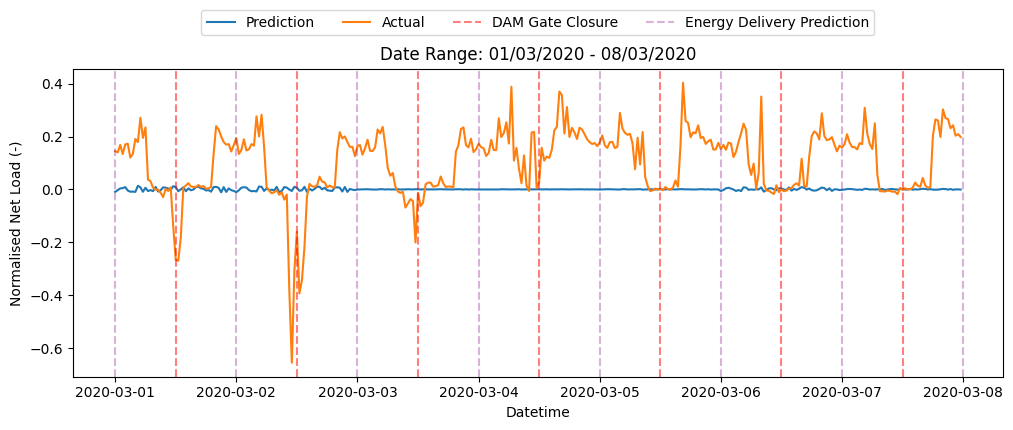

In [44]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 7
end_section = 14
diff = end_section-start_section

df_ts_test = df_input[n_input+n_split:]

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]



predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Date Range: {df_ts_test.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_test.index[end_section*48+48].strftime('%d/%m/%Y')}")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(y_test_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_test.index[start_section*48+72: (end_section)*48+72][::48]

for i, xc in enumerate(xcoords_DAM):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



# Generate vertical lines for DAM closure
xcoords_pred = df_ts_test.index[start_section*48+48: (end_section+1)*48+48][::48]

for i, xc in enumerate(xcoords_pred):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

In [ ]:
import keras_tuner as kt
build_model(kt.HyperParameters())

In [ ]:
rtuner = kt.RandomSearch(hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    seed=12345,
    overwrite=True,
    directory="my_dir",
    project_name="diab")

In [ ]:
rtuner.search(X_train,
              y_train,
              epochs=10,
              validation_data=(X_test, y_test))

In [ ]:
tuned_model = rtuner.get_best_models(num_models=1)

In [ ]:
tuned_model.summary()

In [ ]:
rtuner.get_best_hyperparameters().get_config()['values']